In [1]:
import os
import json
import skimage.io
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt


KeyboardInterrupt



In [ ]:
cresi_dir = '/opt/cresi'
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, 'cresi/configs')
weight_dir = os.path.join(cresi_dir, 'results/aws_weights')
test_im_raw_dir = os.path.join(cresi_dir, 'data/PS-MS')
test_im_clip_dir = os.path.join(cresi_dir, 'data/clips')
test_final_dir = os.path.join(cresi_dir, 'data/final_clips')
results_root_dir = os.path.join(cresi_dir, 'results')
results_dir = os.path.join(results_root_dir, 'dar_tutorial_cpu')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

# make dirs
for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir, mask_stitched_dir, mask_pred_dir]:
    os.makedirs(d, exist_ok=True)

In [3]:
#!aws s3 cp --recursive s3://spacenet-dataset/spacenet-model-weights/spacenet-5/baseline/ {weight_dir}

In [4]:
#!aws s3 ls --no-sign-request --recursive --human-readable --summarize s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS

In [5]:
#!aws s3 cp --recursive s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS/ {test_im_raw_dir}

-----
## 3. Prepare Test Data

While CRESI is designed to handle images of arbitrary size and extent, for this exercise we will clip the image somewhat to speed processing time and ease visualization. We will also convert the 8-band multispectral 16-bit image to an easier to visualize 8-bit RGB image. 

In [6]:
# Clip the image extent
ulx, uly, lrx, lry = 39.25252, -6.7580, 39.28430, -6.7880  # v0

im_name = [z for z in os.listdir(test_im_raw_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)

test_im_raw = os.path.join(test_im_raw_dir, im_name)
test_im_tmp = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip.vrt')
print("temp file:", test_im_tmp)

test_im_clip = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip_60cm.tif')
print("output_file:", test_im_clip)

# clip to extent
!gdal_translate -projwin {ulx} {uly} {lrx} {lry} {test_im_raw} {test_im_tmp}

# resample 30 cm imagery to 60 cm
!gdal_translate -outsize 50% 50% {test_im_tmp} {test_im_clip}

im_name: 000-001-RGB.tif
temp file: /opt/cresi/data/clips/000-001-RGB_clip.vrt
output_file: /opt/cresi/data/clips/000-001-RGB_clip_60cm.tif
Input file size is 5057, 5057
Warning 1: Computed -srcwin 4.41313e+06 2.51733e+07 9147 13347 falls completely outside raster extent. Going on however.
Input file size is 9147, 13347
0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
# Convert 16-bit multispectral test data to 8-bit RGB
%cd {os.path.join(cresi_dir, 'cresi/data_prep/')}
import create_8bit_images

create_8bit_images.dir_to_8bit(test_im_clip_dir, test_final_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[]) # specify [5,3,2] if MS channels. Here we are using RGB itself

# display our test image
fig_width, fig_height = 16, 16
im_test_name = [z for z in os.listdir(test_final_dir) if z.endswith('.tif')][0]
im_test_path = os.path.join(test_final_dir, im_test_name)
im_test = skimage.io.imread(im_test_path)

/opt/cresi/cresi/data_prep
im_files: ['000-001-RGB.tif', '000-001-RGB_clip_60cm.tif']
bmin, bmax: 0255 
zero_frac =  0.0019389010758860126
bmin, bmax: 0 255
zero_frac =  0.0019389010758860126
bmin, bmax: 0 255
zero_frac =  0.0019389010758860126
Conversion_command list: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-a_nodata', '0', '-co', '"PHOTOMETRIC=rgb"', '-b 1', '-scale_1', '14.0', '58.0', '0', '255', '-b 2', '-scale_2', '21.0', '54.0', '0', '255', '-b 3', '-scale_3', '29.0', '59.0', '0', '255', '/opt/cresi/data/clips/000-001-RGB.tif', '/opt/cresi/data/final_clips/000-001-RGB.tif']
Conversion_command str:bmin, bmax:  0gdal_translate -ot Byte -of GTiff -a_nodata 0 -co "PHOTOMETRIC=rgb" -b 1 -scale_1 14.0 58.0 0 255 -b 2 -scale_2 21.0 54.0 0 255 -b 3 -scale_3 29.0 59.0 0 255 /opt/cresi/data/clips/000-001-RGB.tif /opt/cresi/data/final_clips/000-001-RGB.tif 0

zero_frac =  1.0
zero_frac =  1.0 skipping...
Input file size is 5057, 5057
0...10...20...30...40...50...60...70...80...90

In [9]:
im_test.shape

(5057, 5057, 3)

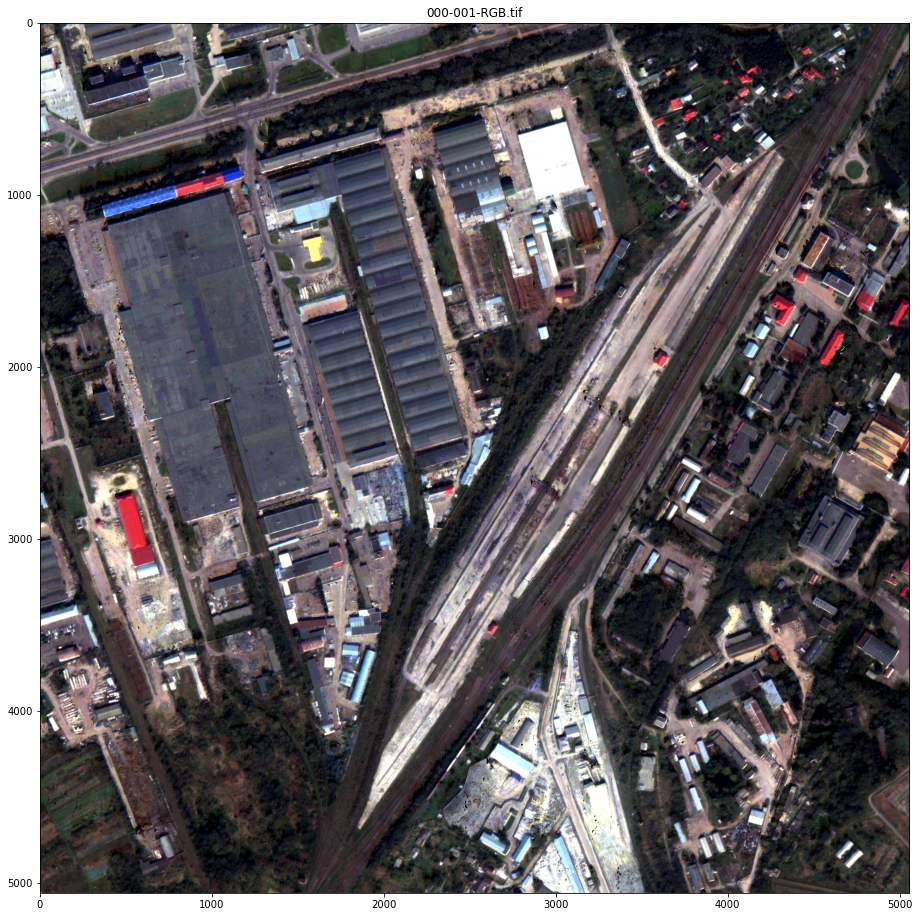

In [10]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im_test.squeeze())
_ = ax.set_title(im_test_name)

-----
## 4. Prepare the config file

CRESI reads from a .json configuration file, and for a pre-trained model executing inference requires only changing a few paths (namely, the testing imagery, model weights, and results paths) in the ```cresi/cresi/configs/dar_tutorial_cpu.json``` file.  These paths should already be set properly, but if not, exectue the cell below.

In [11]:
config_path = os.path.join(config_dir, 'dar_tutorial_cpu.json')
print("config path:", config_path)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    
    data['path_data_root'] = os.path.join(src_dir, 'data')
    
    data['path_results_root'] = results_root_dir
    data['speed_conversion_file'] = os.path.join(config_dir, 'speed_conversion_binned7.csv')
    data['save_weights_dir'] = os.path.join(weight_dir, 'weights') 
    data['test_data_refined_dir'] = test_final_dir
    
    data['test_sliced_dir'] = test_final_dir + '_sliced'
    data['test_results_dir'] = 'dar_tutorial_cpu'

config path: /opt/cresi/cresi/configs/dar_tutorial_cpu.json


In [12]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

print("config data:")
data

config data:


{'path_src': '/opt/cresi/cresi',
 'path_results_root': '/opt/cresi/results',
 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv',
 'save_weights_dir': '/opt/cresi/results/aws_weights/weights',
 'test_data_refined_dir': '/opt/cresi/data/final_clips',
 'test_sliced_dir': '/opt/cresi/data/final_clips_sliced',
 'test_results_dir': 'dar_tutorial_cpu',
 'slice_x': 1300,
 'slice_y': 1300,
 'stride_x': 1280,
 'stride_y': 1280,
 'skeleton_thresh': 0.25,
 'min_subgraph_length_pix': 600,
 'min_spur_length_m': 12,
 'rdp_epsilon': 1,
 'log_to_console': 0,
 'train_data_refined_dir_ims': '',
 'train_data_refined_dir_masks': '',
 'folds_file_name': 'folds4.csv',
 'folds_save_dir': 'folds',
 'tile_df_csv': 'tile_df.csv',
 'merged_dir': 'merged',
 'stitched_dir_raw': 'stitched/mask_raw',
 'stitched_dir_count': 'stitched/mask_count',
 'stitched_dir_norm': 'stitched/mask_norm',
 'wkt_submission': 'wkt_submission_nospeed.csv',
 'skeleton_dir': 'skeleton',
 'skeleton_pkl_dir': 

-----
## 5. Run Inference

The simplest option is to sipmly run the test.sh script (e.g. ```./test.sh configs/dar_tutorial_cpu.json```) which will execute all of the various inference scripts in series.  For this exercise, we will instead run the individual commands to view what's going on at each step.

### 5.1. 02_eval.py 

The 02_eval.py script applies the trained deep learning model to our testing imagery.  First, we tile the imagery into manageable sizes (~800 x 800 meters or 1300 x 1300 pixels). On windows inference proceeds at ~14 seconds per tile, and the entire process completes in 11 minutes for 25 tiles.

While running, you will see a progress bar something like:
```
20%|████████████████████████                                                                                  | 5/25 [02:27<09:42, 29.13s/it]
```

We will kick off inference

In [15]:
%cd {src_dir}
%run -i 01_slice.py { config_path }

/opt/cresi/cresi
Executing tile_im.py..
slice command: python /opt/cresi/cresi/data_prep/tile_im.py /opt/cresi/cresi/configs/dar_tutorial_cpu.json
Output path for sliced images: /opt/cresi/data/final_clips_sliced
processing starting
slicing /opt/cresi/data/final_clips
im_path /opt/cresi/data/final_clips/000-001-RGB.tif
im.shape: (5057, 5057, 3)
n pixels: 25573249
  len df; 16
  Time to slice arrays: 8.70067024230957 seconds
  Total pixels in test image(s): 25573249
df saved to file: /opt/cresi/results/dar_tutorial_cpu/tile_df.csv


In [18]:
%cd {src_dir}
%run -i 02_eval.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
log_file: /opt/cresi/results/dar_tutorial_cpu/test.log
save_dir: /opt/cresi/results/dar_tutorial_cpu/folds
paths: {'masks': '', 'images': '/opt/cresi/data/final_clips_sliced'}
fn_mapping: {'masks': <function <lambda> at 0x7fcdfeebe1f0>}
image_suffix: 
num_workers: 0
fold: 0
run eval.Evaluator.predict()...
prefix: fold0_
Creating datasets within pytorch_utils/eval.py()...
val_indexes:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
len val_dl: 16
self.num_workers 4
Running eval.read_model()...
load model with cpu
  model sucessfully loaded


  0%|                                                                                                                                                | 0/16 [00:00<?, ?it/s]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


  6%|████████▌                                                                                                                               | 1/16 [00:36<09:03, 36.24s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 12%|█████████████████                                                                                                                       | 2/16 [01:15<08:54, 38.20s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 19%|█████████████████████████▌                                                                                                              | 3/16 [01:51<08:04, 37.28s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 25%|██████████████████████████████████                                                                                                      | 4/16 [02:29<07:29, 37.50s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 31%|██████████████████████████████████████████▌                                                                                             | 5/16 [03:09<07:02, 38.37s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 38%|███████████████████████████████████████████████████                                                                                     | 6/16 [03:45<06:15, 37.59s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 44%|███████████████████████████████████████████████████████████▌                                                                            | 7/16 [04:23<05:38, 37.57s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 50%|████████████████████████████████████████████████████████████████████                                                                    | 8/16 [04:59<04:55, 36.98s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 56%|████████████████████████████████████████████████████████████████████████████▌                                                           | 9/16 [05:37<04:22, 37.51s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                  | 10/16 [06:14<03:44, 37.34s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 11/16 [06:53<03:09, 37.94s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 12/16 [07:32<02:32, 38.16s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 13/16 [08:11<01:55, 38.45s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 14/16 [08:50<01:17, 38.66s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 15/16 [09:30<00:38, 38.99s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [10:09<00:00, 38.10s/it]

Time to run 1 folds for 16 = 614.0626518726349 seconds


-----
### 5.1. 02_eval.py (continued)

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

In [19]:
# inspect
mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__5120__6400__1300__1300__11770__11111.tif'

mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__0__0__1300__1300__11770__11111.tif'

mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

FileNotFoundError: [Errno 2] No such file or directory: '/opt/cresi/results/dar_tutorial_cpu/folds/fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__0__0__1300__1300__11770__11111.tif'

-----
### 5.2. 03b_stitch.py

The output of 02_eval.py is a series of chipped prediction masks, which we stitch back together (using the procedure illustrated below) in order to produce the aggregate prediction mask.  

<br>
<img src="images/basiss_test.jpg" alt="Drawing" style="height: 500px;"/>
<br>

The command below takes ~20 seconds to run for our test image, and creates the total mask. Many road extraction algorithms end here once a road pixel mask has been produced.  We still have a few more steps to go, however.

In [20]:
%cd {src_dir}
%run -i 03b_stitch.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Running stitch.py...
post_process_image - w, h: 5057 5057
0 / 16
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 4
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 5057, 5057)
mask_norm.dtype: uint8
Time to run stitch.py and create large masks (and save): 14.175600051879883 seconds


mask_pred.shape: (8, 5057, 5057)


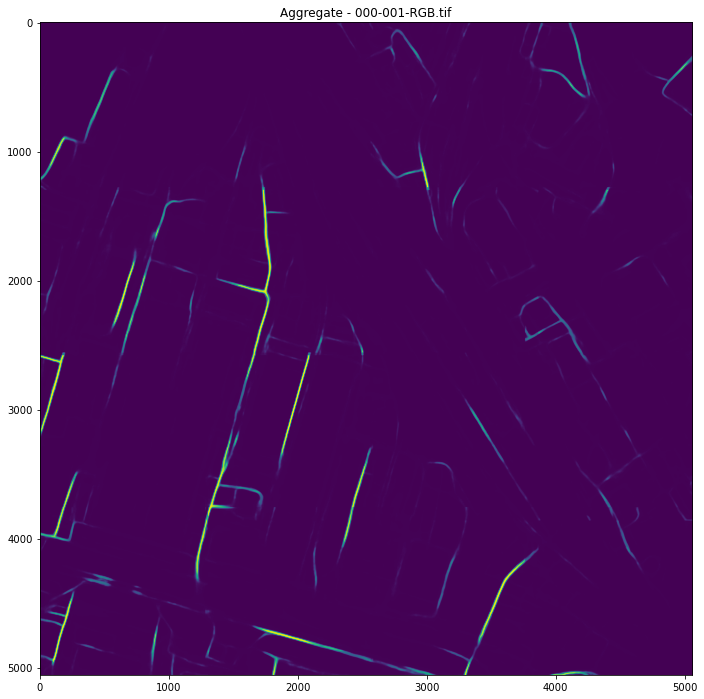

In [21]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

-----
### 5.3. 04_skeletonize.py

The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

Steps 1-3 are summarized in the figure below:

<br>
<img src="images/skeletonize.png" alt="Drawing" style="height: 180px;"/>
<br>

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed, and should take ~20 seconds to run.

In [22]:
%run -i 04_skeletonize.py configs/dar_tutorial_cpu.json

min_spur_length_pix: 20
Use_medial_axis? False
im_dir: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm
out_ske_dir: /opt/cresi/results/dar_tutorial_cpu/skeleton
out_gdir: /opt/cresi/results/dar_tutorial_cpu/sknw_gpickle

 1 / 1 : 000-001-RGB.tif
  img_loc: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm/000-001-RGB.tif
  im_root: 000-001-RGB
  out_ske_file: /opt/cresi/results/dar_tutorial_cpu/skeleton/000-001-RGB.tif
Executing make_skeleton...
make_skeleton(), input img_shape: ()
make_skeleton(), img.shape: (5057, 5057)
make_skeleton(), img.size: 25573249
make_skeleton(), img dtype: uint8
Run preprocess()...
Time to run preprocess(): 1.8710920810699463 seconds
skeletonize...
Time to run skimage.skeletonize(): 1.5704808235168457 seconds
fix_borders...
Time fix borders: 0.01882338523864746 seconds
ske.shape: (5057, 5057)
Time to run make_skeleton: 4.619374513626099 seconds
Execute sknw...
225 random node props: {'pts': array([[5054, 4297]], dtype=int16), 'o': array([5054., 

In [23]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

,ImageId,WKT_Pix
0,000-001-RGB,"LINESTRING (3887.0 2.0, 3885.0 17.0, 3869.0 54..."
1,000-001-RGB,"LINESTRING (4102.0 2.0, 4110.0 36.0, 4134.0 90..."
2,000-001-RGB,"LINESTRING (3849.0 116.0, 3825.0 189.0)"
3,000-001-RGB,"LINESTRING (2723.0 126.0, 2726.0 107.0, 2738.0..."
4,000-001-RGB,"LINESTRING (2714.0 196.0, 2686.0 204.0)"


-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [28]:
%run -i 05_wkt_to_G.py configs/dar_tutorial_cpu.json 

image_ids: ['000-001-RGB']
len image_ids: 1
0
image_file: /opt/cresi/data/final_clips/000-001-RGB.tif
  wkt_list[:2] ['LINESTRING (3887.0 2.0, 3885.0 17.0, 3869.0 54.0, 3860.0 87.0)'
 'LINESTRING (4102.0 2.0, 4110.0 36.0, 4134.0 90.0, 4143.0 118.0, 4172.0 233.0, 4185.0 309.0, 4231.0 464.0, 4253.0 565.0)']
im_file: /opt/cresi/data/final_clips/000-001-RGB.tif
Running wkt_list_to_nodes_edges()...
Time to run wkt_list_to_nodes_egdes(): 0.09866905212402344 seconds
Creating G...
  len(G.nodes(): 512
  len(G.edges(): 454
Time to run nodes_edges_to_G(): 0.06203198432922363 seconds
Clean out short subgraphs
Running clean_sub_graphs...
  sub_graph node count: [8, 8, 11, 4, 13, 9, 10, 2, 2, 10, 15, 4, 2, 2, 72, 5, 6, 3, 16, 3, 7, 10, 3, 3, 4, 6, 6, 23, 7, 3, 3, 11, 16, 5, 2, 2, 2, 2, 8, 5, 16, 2, 3, 10, 7, 11, 8, 18, 2, 4, 23, 3, 21, 7, 3, 8, 9, 3, 13, 8]
  len(G_.nodes()): 512
  len(G_.edges()): 454
 num bad_nodes: 275
 len(G'.nodes()): 237
 len(G'.edges()): 224
Time to run clean_sub_graphs(): 0

In [25]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))

IndexError: list index out of range